In [1]:
import cv2
import os, sys
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import seaborn as sns
# import SimpleITK as sitk
import re

In [2]:
material_path = '/QRISdata/Q1851/Minh/RNAScope'
round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
round2_dapi = '2020_05_06_R2_DAPI_TIFF'
dapi_1 = os.path.join(material_path, round1_dapi, '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif')
dapi_2 = os.path.join(material_path, round2_dapi, '2020_05_06_R2_DAPI_TIFF_s1z1c3.tif')

In [3]:
def get_files_in_directory(directory, postfix=""):
    fileNames = [s for s in os.listdir(directory) if not os.path.isdir(os.path.join(directory, s))]
    if not postfix or postfix == "":
        return sorted(fileNames)
    else:
        return sorted([s for s in fileNames if s.lower().endswith(postfix)])
    
def get_subdirectories_in_directory(directory, postfix=""):
    dir_names = [s for s in os.listdir(directory) if os.path.isdir(os.path.join(directory, s))]
    return sorted(dir_names)

def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

In [4]:
# imgs_2probes = get_files_in_directory(tif_2probes, 'tif')
# imgs_5probes = get_files_in_directory(tif_5probes, 'tif')
# dapi_1 = tif_1 #os.path.join(tif_5probes, imgs_5probes[-1])
# dapi_2 = tif_2 #os.path.join(tif_2probes, imgs_2probes[-1])
print(dapi_1, dapi_2)

/QRISdata/Q1851/Minh/RNAScope/2020_05_05_R1_DAPI_TIFF/2020_05_05_R1_DAPI_TIFF_s1z1c4.tif /QRISdata/Q1851/Minh/RNAScope/2020_05_06_R2_DAPI_TIFF/2020_05_06_R2_DAPI_TIFF_s1z1c3.tif


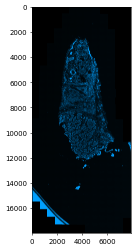

In [5]:
img_dapi1 = cv2.cvtColor(cv2.imread(dapi_1), cv2.COLOR_BGR2RGB)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img_dapi1)
# plt.show()

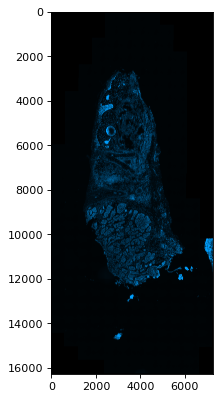

In [7]:
img_dapi2 = cv2.cvtColor(cv2.imread(dapi_2), cv2.COLOR_BGR2RGB)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img_dapi2)
# plt.show()

In [8]:
# print(img_dapi2.shape)
# print(img_dapi5.shape)
# img_dapi5_gray = cv2.cvtColor(img_dapi5, cv2.COLOR_RGB2GRAY)
# img_dapi2_gray = cv2.cvtColor(img_dapi2, cv2.COLOR_RGB2GRAY)

(403, 1079, 3)
(403, 1079, 3)


In [8]:
img_dapi1_crop = cv2.cvtColor(img_dapi1, cv2.COLOR_RGB2GRAY)
img_dapi2_crop = cv2.cvtColor(img_dapi2, cv2.COLOR_RGB2GRAY)
# Image.fromarray(img_dapi1_crop)

In [9]:
# Image.fromarray(img_dapi2_crop)

In [10]:
def scale_img(img, scale_factor):
    #Scales pillow images with constant scale factor
    #img: is the annotated image
    #scale_factor: scaling scalar 
    new_width = int(round(img.shape[1]*scale_factor))
    new_height = int(round(img.shape[0]*scale_factor))
    return cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_CUBIC )

def register_by_scaling_img(moving_img, template_img, detail_level = 30):
    best_loc = (0,0)
    best_scale = 0
    best_max_val = 0
    max_vals = []
    w_m, h_m = moving_img.shape
    w_t, h_t = template_img.shape
    w_factor = w_m/w_t
    h_factor = h_t/h_m
    search_space = np.linspace(w_factor, h_factor, detail_level)
    for scale_factor in search_space:
        moving_img_scaled = scale_img(moving_img, scale_factor)
        moving_img_scaled = np.array(moving_img_scaled)
        result = cv2.matchTemplate(moving_img, template_img, cv2.TM_CCOEFF_NORMED)
        sin_val, max_val, min_loc, max_loc=cv2.minMaxLoc(result)
        max_vals.append(max_val)
        if max_val > best_max_val:
            best_max_val = max_val
            best_scale = scale_factor
            best_loc = max_loc
    return best_loc, best_scale, max_vals, search_space

In [12]:
best_loc = (0,0)
best_scale = 0
best_max_val = 0
max_vals = []
# print(img_dapi2_crop.shape[0]/img_dapi5_crop.shape[0])
# print(img_dapi2_crop.shape[1]/img_dapi5_crop.shape[1])

# print(img_dapi2_crop.shape)
# print(img_dapi5_crop.shape)
# resize_factor = img_dapi2_crop.shape[1]/ img_dapi5_gray.shape[1]
# img_dapi5_crop_resize = cv2.resize(img_dapi5_crop, (img_dapi2_crop.shape[1], 
#                                                     int(img_dapi2_crop.shape[0]/resize_factor)))
# img_dapi
search_space = np.linspace(0.8, 1.01, 15)
for scale_factor in search_space:
    img_dapi2_scaled = scale_img(img_dapi2_crop, scale_factor)
    img_dapi2_scaled = np.array(img_dapi2_scaled)  
    img_dapi2_scaled_gray = img_dapi2_scaled
#     print(img_dapi5_crop_resize.shape)
#     print(img_dapi5_crop.shape)
    result = cv2.matchTemplate(img_dapi2_scaled_gray, img_dapi1_crop, cv2.TM_CCOEFF_NORMED)
    sin_val, max_val, min_loc, max_loc=cv2.minMaxLoc(result)
    max_vals.append(max_val)
    if max_val > best_max_val:
        best_max_val = max_val
        best_scale = scale_factor
        best_loc = max_loc
print(best_loc, best_scale, best_max_val)

(698, 84) 0.98 0.6389637589454651


Text(0, 0.5, 'Max. Normalised Correlation Coefficient')

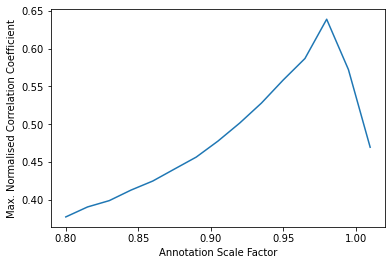

In [13]:

sns.lineplot(x= search_space, y=max_vals)
plt.xlabel('Annotation Scale Factor')
plt.ylabel('Max. Normalised Correlation Coefficient')

In [14]:
# top_left=best_loc
# #increasing the size of bounding rectangle by 50 pixels
# annotation_width = int(round(img_dapi2_crop.shape[0]*best_scale))
# annotation_height = int(round(img_dapi2_crop.shape[1]*best_scale))
# bottom_right=(top_left[0]+annotation_width,top_left[1]+annotation_height)
# print(bottom_right)
# print(img_dapi5_crop.shape)
# overlay = cv2.rectangle(img_dapi5_crop.copy(), top_left, bottom_right, (0,255,0),4)
# fig, a = plt.subplots(figsize = (20,20))
# plt.imshow(overlay, cmap = plt.cm.gray)

In [108]:
background = Image.fromarray(img_dapi1)
foreground = Image.fromarray(scale_img(cv2.cvtColor(img_dapi2, cv2.COLOR_BGR2RGB), best_scale))
newimg1 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
best_loc_1 = best_loc
# best_loc_1 = (610, -20)
newimg1.paste(foreground, best_loc_1)
newimg1.paste(background, (0, 0))

newimg2 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
newimg2.paste(background, (0, 0))
newimg2.paste(foreground, best_loc_1 )
result = Image.blend(newimg1, newimg2, alpha=0.5)
# result


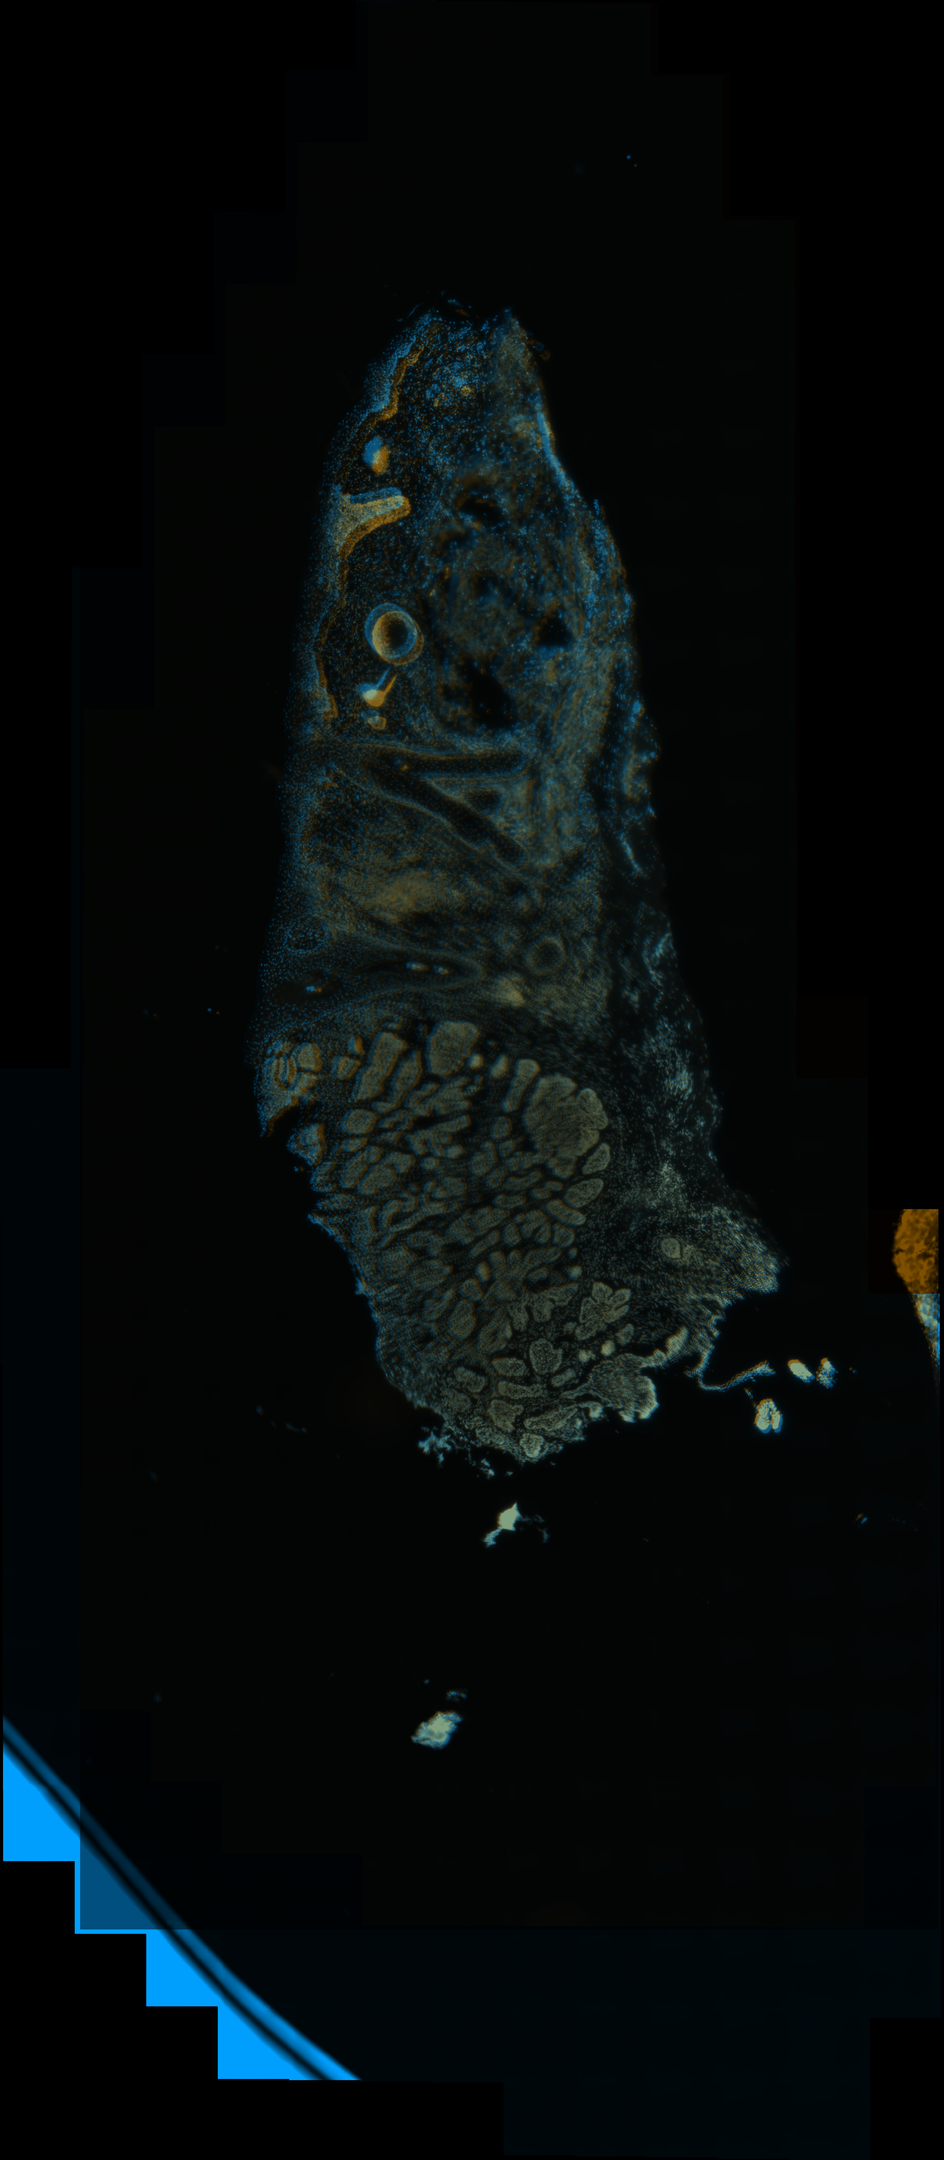

In [109]:
result.thumbnail((2160,2160), Image.ANTIALIAS)
result

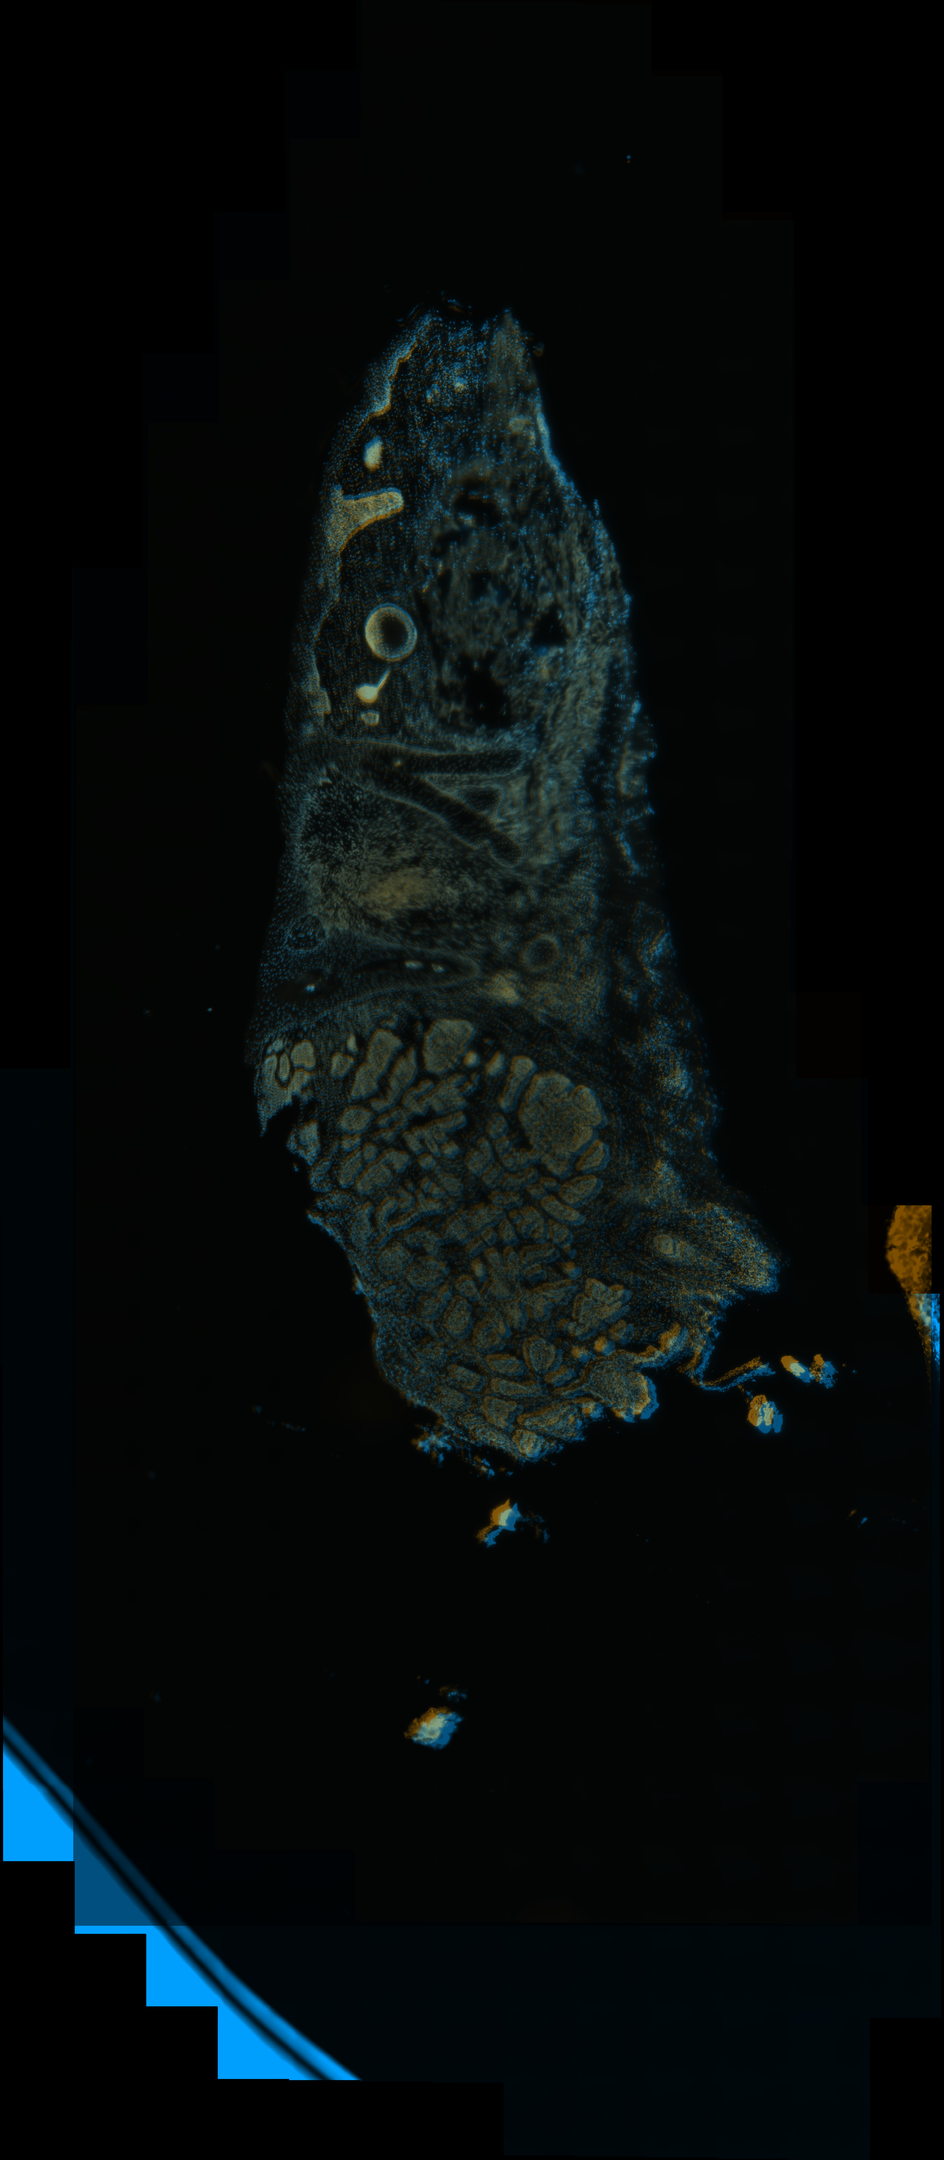

In [106]:
result.thumbnail((2160,2160), Image.ANTIALIAS)
result

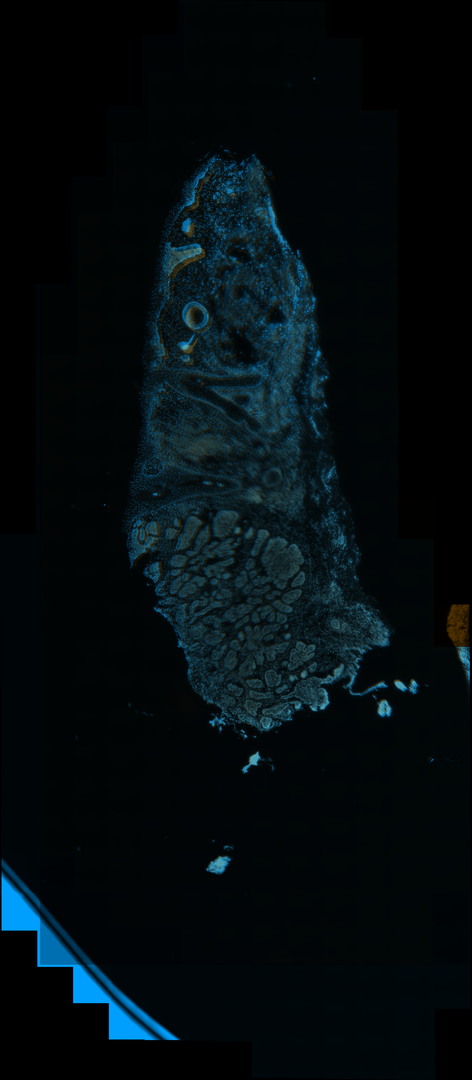

In [40]:
result_2 = Image.blend(newimg1, newimg2, alpha=0.3)
result_2.thumbnail((1080,1080), Image.ANTIALIAS)
result_2

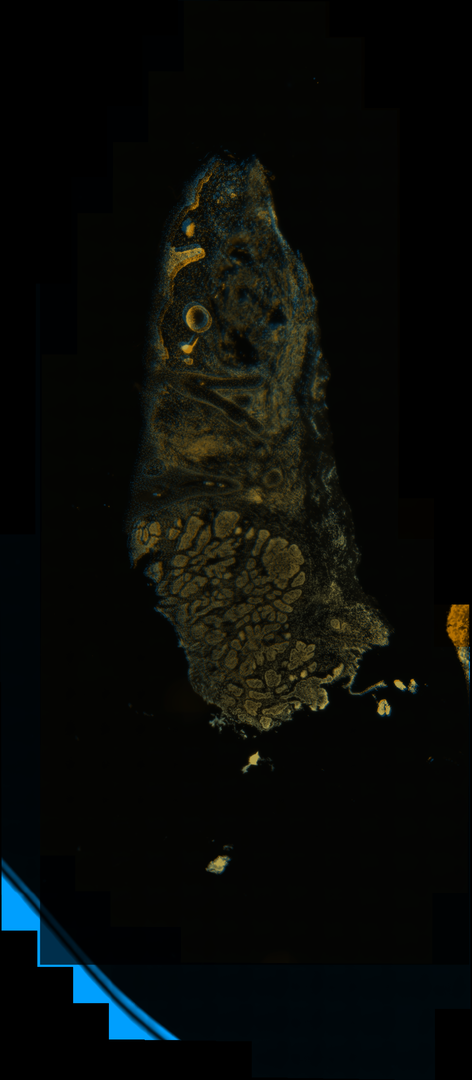

In [41]:
result_1 = Image.blend(newimg1, newimg2, alpha=0.7)
result_1.thumbnail((1080,1080), Image.ANTIALIAS)
result_1

In [13]:
result=result.convert('RGB')
result.save('register_1.jpg')